# PyMC3

In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

rd.seed(0xC0FFEE)

%matplotlib inline

* In the Theano presentation we showed at how we could automate inference for arbitrary functions, i.e. models., 
* This allowing us to escape from the confines of `scikit-learn` if we want.
    * However `scikit-learn` is really comprehensive, and it's always best to start with it first, and use it as far as possible.
* PyMC is a model automation engine on top of Theano
    * However instead of taking arbitrary functions, it takes a fully defined, _Bayesian_ probability distribution
    * This is sometimes called "Probabilistic Programming"


# Inference in General

Most supervised machine learning has input-output pairs $(\boldsymbol{x}_i, y_i)$ for $i \in \{1 \ldots N\}$. Often you have many (e.g. $F$) input features, so $\boldsymbol{x}_i \in \mathbb{R}^{F \times 1}$. These are usually collected into a matrix $X \in \mathbb{R}^{N \times F}$ and a vector $\boldsymbol{y} \in \mathbb{N \times 1}$

Assuming there's some parameter $\boldsymbol{w}$ that relates your inputs to your outputs (e.g. $\boldsymbol{y} = X \boldsymbol{w}$. How do you find a values for it?

## Step 1: The model specification

Decide how your parameters are combined with your inputs to create your outputs: e.g. linear regression

$$\boldsymbol{y} = X \boldsymbol{w}$$

Probably our data are a bit noisy, so this won't explain what we see. Lets add some noise 

$$\boldsymbol{y} = X \boldsymbol{w} + \boldsymbol{\epsilon}$$


### Step 1a: The noise distribution
What does our noise look like. Lets assume it's

<img style='float:right' src='lin-reg.png'/>
<div style="width:50%">

 1. Equally likely to be positive or negative
 2. The same magnitude all values $\epsilon_1 = \epsilon_2 = \ldots \epsilon_N$
 3. Centred at zero, so there's no unexplained trend (restates (1))


Then there are two options:

 1. $\epsilon_i \sim \text{Nor}\left(0, \sigma^2\right)$ for all $i \in \{1 \ldots N \}$
 2. $\epsilon_i \sim \text{Laplace}\left(0, \sigma^2\right)$ for all $i \in \{1 \ldots N \}$
    

</div>
 
The normal distribution is standard as it makes the maths easy. The Laplace encodes a preference to ignore outliers (it has "heavier tails"). However it makes the maths hard, so for that reason so-called "robust" regression uses a different method.


### Step 1b: The final model
    
    
Hence our final model is

$$
\begin{align*}
\boldsymbol{y} & = X \boldsymbol{w} + \boldsymbol{\epsilon}\quad, &
\boldsymbol{\epsilon} & \sim \text{Nor}_N\left(\boldsymbol{0}, \sigma^2 I_N \right)
\end{align*}
$$

This is linear regression. In practice $\boldsymbol{\epsilon}$ is the distribution of your residuals, so it doesn't appear in your inference.

## Step 2: Error Function

The way you figure out what the best value for your parameter should be is to reduce the difference between your estimate ($\boldsymbol{w}^\top \boldsymbol{x}_i$) and your observed value $y_i$.

You measure this using an error function. What should an error function look like?

 0. It should reflect the _purpose_ of the model: regression and classification are different tasks that will have different functions.
 1. For regression it should capture the magnitude of the error, and ignore the direction (3 units too big is equally as bad as 3 units too small)
 2. Typically (not always) you need this to be differentiable and continuous since most inference mechanisms rely on taking derivatives (maybe automatically!).
 
For regression the classic function is the mean squared error

$$
\begin{align*}
E(\boldsymbol{w}) = MSE(\boldsymbol{w}) & = \frac{1}{N} \sum_{i=1}^N (y_i - \boldsymbol{w}^\top\boldsymbol{x}_i)^2 \\
 & = \frac{1}{N} (\boldsymbol{y} - X \boldsymbol{w})^\top(\boldsymbol{y} - X \boldsymbol{w})
\end{align*}
$$

This is exactly the variance of the residuals, i.e. it's an estimate for $\sigma^2$ in $\epsilon \sim \text{Nor}(0, \sigma^2)$

## Step 3: Add a Penalty

The error function is small for good values for $\boldsymbol{w}$ and high for poor values of $\boldsymbol{w}$.

However it may find non-sensible versions of $\boldsymbol{w}$ in an effort to fit noise. This is overfitting. 

To stop that you add a second "error" function that's small for _sensible_ values of $\boldsymbol{w}$ and high for nonsensenical values of $\boldsymbol{w}$. This is called the "penalty". 

For regression, overfitting tends to manifest as very steep slopes, positive or negative. We want to keep the slopes small, so we just penalise the sum of squares

$$R(\boldsymbol{w}) = \sum_i w_i^2 = \boldsymbol{w}^\top\boldsymbol{w} = ||\boldsymbol{w}||_2^2$$

Why do you use squares? Because like an error function this needs to (1) reflect our intent (2) be differentiable and continuous.

## Step 4: The Final Inference Problem

We need to find the value of $\boldsymbol{w}$ that minimises our _regularlized_ error function

$$
\begin{align*}
\mathcal{L}(\boldsymbol{w}) & = E(\boldsymbol{w}) + \lambda R(\boldsymbol{w}) \\
 & = \frac{1}{N} (\boldsymbol{y} - X \boldsymbol{w})^\top(\boldsymbol{y} - X \boldsymbol{w}) + \lambda ||\boldsymbol{w}||_2^2 \\
 & = \frac{1}{N} (\boldsymbol{y} - X \boldsymbol{w})^\top(\boldsymbol{y} - X \boldsymbol{w}) - \lambda \boldsymbol{w}^\top \boldsymbol{w}
\end{align*}
$$

This is the formula for "Ridge Regression" and the term $\lambda$ determines how much you're willing to accept (or refuse to accept) a nonsensical value to improve the model fit.

There are lots of ways of solving this. One is to take the first derivative, and see when it's zero. 

![](error-fn.jpg)

The other is to just take a step in the opposite direction to the gradient. As we showed in the previous section, we can have Theano figure out the gradient for us.

![](error-fn-grad-desc.jpg)

To fully automate this however, you'd like a family of error functions and penalty functions for every case, possibly with some more sophisticated inference schemes that could also give you confidence bounds.

This is PyMC

# Bayesian Inference and PyMC

Bayesian inference is composed of three steps. At the start you specify two things:

* **The Prior** An initial guess of what a reasonable value for your parameter $\boldsymbol{w}$: $p(\boldsymbol{w})$.
    * This is the opposite of the penalty, the lower the penalty, the higher the prior probability
* **The Likelihood** The probablity of your outputs given the inputs and your parameter $p(\boldsymbol{y} | X, \boldsymbol{w})$
    * This is opposite of an error function: the lower the error, the higher the likelihood probability


Then by combining the observed data and the prior, you can obtain the **posterior**

$$
\begin{align*}
p(\boldsymbol{w}|X, \boldsymbol{y}) =
\frac{
    p(\boldsymbol{y} | X, \boldsymbol{w}) p(\boldsymbol{w})
} {
    \int p(\boldsymbol{y} | X, \boldsymbol{w}) p(\boldsymbol{w}) d\boldsymbol{w}
}
\end{align*}
$$

Note that in the Bayesian approach you don't just get a value, you get a distribution -- e.g. a mean and a spread -- and so you can get a spread around your estimates.

Also, Bayesian inference is infinitely recursive: if you get a new batch of input date ($X^{(2)}, \boldsymbol{y}^{(2)})$ you can re-use an old posterior as the new prior, e.g.

$$
p(\boldsymbol{w}|X^{(2)}, \boldsymbol{y}^{(2)}) =
\frac{
    p(\boldsymbol{y}^{(2)} | X^{(2)}, \boldsymbol{w}) p(\boldsymbol{w}|X, \boldsymbol{y})
} {
    \int p(\boldsymbol{y}^{(2)} | X^{(2)}, \boldsymbol{w}) p(\boldsymbol{w}|X, \boldsymbol{y}) d\boldsymbol{w}
}
$$

## Three kinds of probabilistic inference:
    
1. Maximum likelihood: Find a value for $\boldsymbol{w}$ that maximises $\ln p(\boldsymbol{y}|X, \boldsymbol{w})$: 
    1. same as working with an error function with no penalty
2. Maximum a Posteriori (MAP): Find a value for $\boldsymbol{w}$ that maximises $\ln p(\boldsymbol{y}|X, \boldsymbol{w}) + \ln p(\boldsymbol{w})$: 
    1. same as working with an error function _with_ penalty.
3. Fully Bayesian infernce: find a _distribution_ for $\boldsymbol{w}$ (and hence bounds) which _solves_ $p(\boldsymbol{w}|X, \boldsymbol{y}) =
\frac{
    p(\boldsymbol{y} | X, \boldsymbol{w}) p(\boldsymbol{w})
} {
    \int p(\boldsymbol{y} | X, \boldsymbol{w}) p(\boldsymbol{w}) d\boldsymbol{w}
}$
    1. This has no equivalent
    


### MLE vs MAP vs Bayes

These methods will not give the same answer. 
 * MLE and MAP both find the most likely value of a parameter (the mode). 
 * The MLE will overfit. 
 * The MAP will overfit less, and so be slighly different. 
 * The Bayesian method will consider the spread of the distribution, and for certain distrbutions that will change the answer again, as the mean of a random variable is not always the most likely value of a random variable.

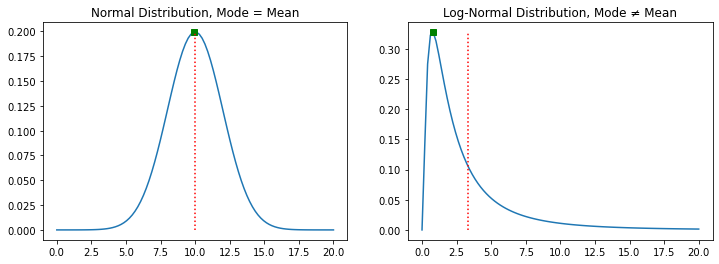

In [2]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)

xs = np.linspace(0, 20, 100)
ys = stats.norm.pdf(xs, loc=10, scale=2)
max_i = np.argmax(ys)
axes[0].plot(xs, ys)
axes[0].plot(xs[max_i], ys[max_i], 'gs')
axes[0].plot([10, 10], [0, ys[max_i]], 'r:')
axes[0].set_title('Normal Distribution, Mode = Mean');

mn = stats.lognorm.mean(loc=0, scale=2, s=1)
ys = stats.lognorm.pdf(xs, loc=0, scale=2, s=1)
max_i = np.argmax(ys)
axes[1].plot(xs, ys)
axes[1].plot(xs[max_i], ys[max_i], 'gs')
axes[1].plot([mn, mn], [0, ys[max_i]], 'r:')
axes[1].set_title('Log-Normal Distribution, Mode ≠ Mean');

## Baysian Linear Regression

### Prior 

For weights, the Normal is the best option usually: so $\boldsymbol{w} \sim \text{Nor}(\boldsymbol{0}, \alpha^2 I)$

$$
\begin{align*}
p(\boldsymbol{w})&  = (2 \pi \alpha^2)^{K/2} \exp\left( (\boldsymbol{0} - \boldsymbol{w})^\top \frac{1}{2 \alpha^2}I (\boldsymbol{0} - \boldsymbol{w})\right) \\
 & = (2 \pi \alpha^2)^{K/2} \exp\left( \frac{1}{2} \alpha^{-2}\boldsymbol{w}^\top\boldsymbol{w}\right) \\
\implies \ln p(\boldsymbol{w}) & = -\frac{K}{2} \ln (2 \pi \alpha^2 ) - \frac{1}{2} \alpha^{-2}\boldsymbol{w}^\top\boldsymbol{w} \\
& \propto -\frac{1}{2\alpha^{2}} ||\boldsymbol{w}||_2^2
\end{align*}
$$

### Likelihood

It makes the maths easy if you choose the right combination of prior and likelihood. Typically this ends up in the posterior distribution having the same form as the prior. These are called _conjugate priors_, and there's a good page on Wikipedia that tells us which likelihoods and priors fit well together.

If you don't use conjugate priors, some inference mechanisms won't work, others like MCMC will, but will be slow.

Wikipedia has a handy [Table of Conjugate Priors](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions). From this we see that really the only choice is for the likelihood to be normally distributed too, which just makes sense. In the Bayesian case, we feed in the noise $\sigma^2$ into the distribution over $\boldsymbol{y}$ instead of making it a separate random variable $\epsilon$

So $\boldsymbol{y} \sim \text{Nor}_N(X \boldsymbol{w}, \sigma^2)$. If you do the sums, you'll see the log likelihood is the negative sum of square errors.

$$
\begin{align*}
\ln(\boldsymbol{y} | X, \boldsymbol{w}) & = 
    -\frac{D}{2}\ln (2 \pi \sigma^2) - \frac{1}{2 \sigma^2} (\boldsymbol{y} - X\boldsymbol{w})^\top(\boldsymbol{y} - X\boldsymbol{w}) \\
    & \propto -\frac{1}{2 \sigma^2} (\boldsymbol{y} - X\boldsymbol{w})^\top(\boldsymbol{y} - X\boldsymbol{w})
\end{align*}
$$

which is the negative sum of squares error function.

Note that by gathering terms, and multiplying across by $2 \sigma^2$ we see that the ridge penalty $\lambda = \frac{\sigma^2}{\alpha^2}$

### MAP versus Regularised Loss Optimiation 

So we've shown that

$$
\ln p(\boldsymbol{y} | X \boldsymbol{w}) + \ln p(\boldsymbol{w}) \propto -D \times E(\boldsymbol{w}) - \lambda R(\boldsymbol{w})
$$

which means that maximising the left-hand side will minimise our regularised loss $E(\boldsymbol{w}) + \lambda R(\boldsymbol{w})$

Or put another way, doing MAP estimation in a Bayesian setting is the same as doing regularised function optimisation in an algebraic setting.

# Finally an Example in Practice

In [3]:
import theano
import theano.tensor as T
import pymc3 as pm

In [4]:
# theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [5]:
real_σ = 10
real_w = np.array([2, 10])
X = np.array([np.linspace(1, 50, 50), [1] * 50]).T
y = X @ real_w + rd.randn(50) * real_σ

/home/bfeeney/anaconda3/envs/pymc3-theano-presentation/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


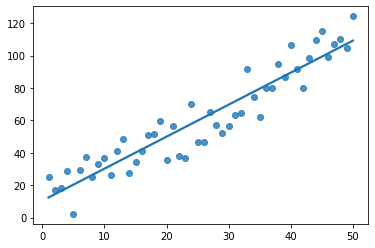

In [6]:
sns.regplot(X[:,0], y, ci=None);

In [7]:
with pm.Model() as linear_regression:
    a = pm.InverseGamma('a', 1, 1)
    w = pm.Normal('w', mu=0, sd=a, shape=2)
    
    σ = pm.InverseGamma('σ', 1, 1)
    y_est = pm.Normal('y', mu=T.dot(X, w), sd=σ, observed=y)

In [8]:
with linear_regression:
    soln = pm.find_MAP()

In [9]:
soln

{'a_log__': array(0.94506466),
 'w': array([2.15481142, 4.38909415]),
 'σ_log__': array(2.35819024),
 'a': array(2.57297973),
 'σ': array(10.57180171)}

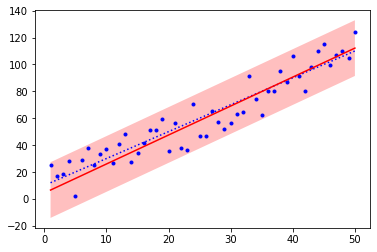

In [10]:
plt.plot(X[:,0], y, 'b.')
plt.plot(X[:,0], X @ real_w, 'b:')

plt.plot(X[:,0], X @ soln['w'], 'r-')
plt.fill_between(X[:,0], 
                 X @ soln['w'] - 1.96 * soln['σ'],
                 X @ soln['w'] + 1.96 * soln['σ'],
                 facecolor='red', alpha=0.25)

### MCMC Sampling

The derivation of MCMC is way beyond this talk. It's a probabilistic way of search for _distributions_ over the parameters, until you arrive at a distribution that fits.

In [11]:
with linear_regression:
    samples = pm.sample(draws=500, tune=500, chains=4)

/tmp/ipykernel_483595/169378177.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  samples = pm.sample(draws=500, tune=500, chains=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, w, a]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [12]:
samples['w'].shape

(2000, 2)

/home/bfeeney/anaconda3/envs/pymc3-theano-presentation/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bfeeney/anaconda3/envs/pymc3-theano-presentation/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

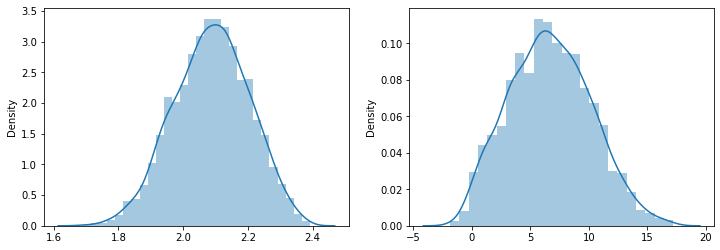

In [13]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
sns.distplot(samples['w'][:,0], ax=axes[0])
sns.distplot(samples['w'][:,1], ax=axes[1])

/home/bfeeney/anaconda3/envs/pymc3-theano-presentation/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'w\n0'}>,
       <AxesSubplot:title={'center':'w\n1'}>,
       <AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'σ'}>], dtype=object)

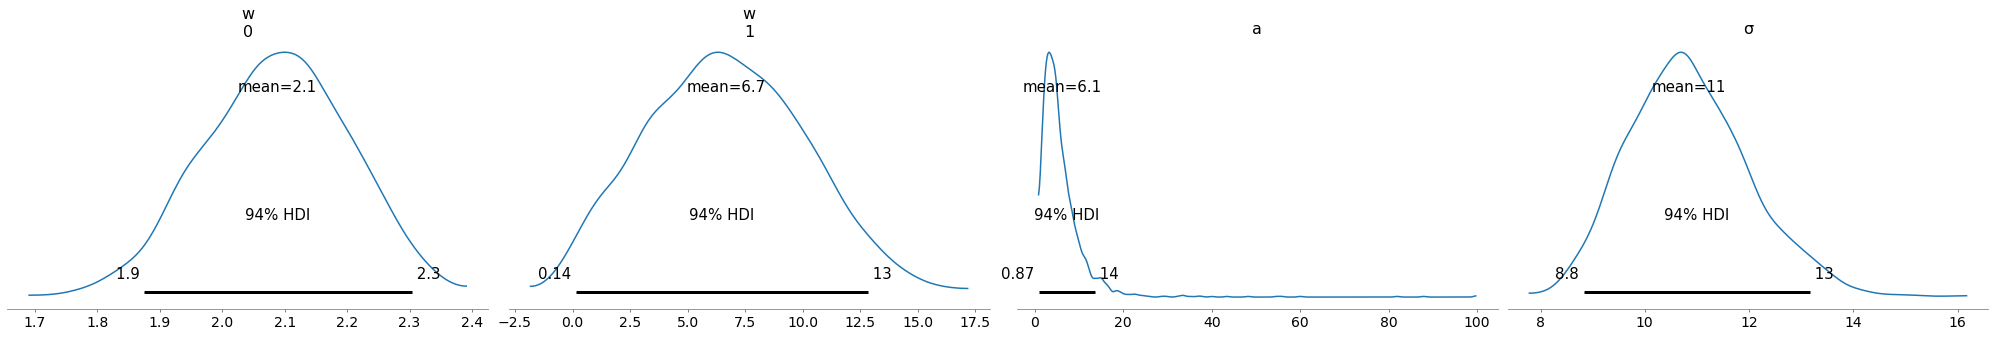

In [14]:
pm.plots.plot_posterior(samples)

HPD is the "highest posterior density" region, i.e. it's the most likely range of values.

/tmp/ipykernel_483595/2111944006.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(samples)
/home/bfeeney/anaconda3/envs/pymc3-theano-presentation/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

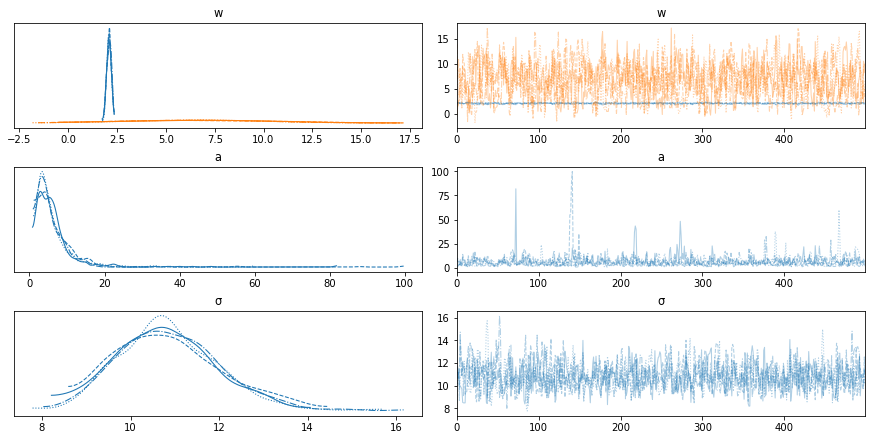

In [15]:
pm.traceplot(samples)

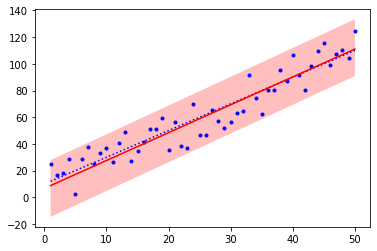

In [16]:
plt.plot(X[:,0], y, 'b.')
plt.plot(X[:,0], X @ real_w, 'b:')

plt.plot(X[:,0], X @ samples['w'].mean(axis=0), 'r-')
plt.fill_between(X[:,0], 
                 X @ soln['w'] - 1.96 * samples['σ'].mean(),
                 X @ soln['w'] + 1.96 * samples['σ'].mean(),
                 facecolor='red', alpha=0.25)

In [17]:
y_preds = X @ samples['w'].T
sigmas = y_preds + 1.96 * samples['σ']
sigmas = y_preds - 1.96 * samples['σ']
y_preds.shape

(50, 2000)

In [18]:
y_upper = np.percentile(y_preds, 95, axis=1)
y_lower = np.percentile(y_preds,  5, axis=1)

In [19]:
y_upper.shape, y_lower.shape

((50,), (50,))

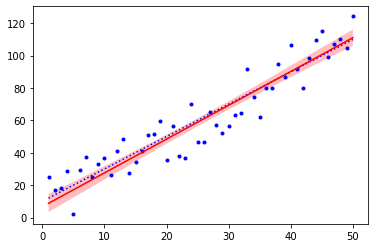

In [20]:
plt.plot(X[:,0], y, 'b.')
plt.plot(X[:,0], X @ real_w, 'b:')

plt.plot(X[:,0], X @ samples['w'].mean(axis=0), 'r-')
plt.fill_between(X[:,0], 
                 y_lower,
                 y_upper,
                 facecolor='red', alpha=0.25)